In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [4]:
def run_command(c):
    with sqlite3.connect ('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_tables():
    q = 'SELECT name, type FROM sqlite_master\
         WHERE type IN ("table","view");'
    return run_query(q)

In [6]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [7]:
q = "WITH\
    intr as (SELECT inv.billing_country ct, genre_id genre FROM track t \
             INNER JOIN invoice_line il ON il.track_id=t.track_id\
             INNER JOIN invoice inv ON inv.invoice_id=il.invoice_id)\
    SELECT g.name genre, count(*) sales FROM intr\
    INNER JOIN genre g ON g.genre_id=intr.genre\
    GROUP BY genre HAVING intr.ct='USA';"
genre_sales_usa = run_query(q)

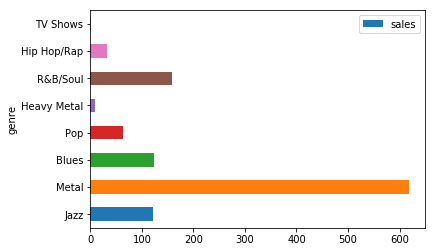

In [8]:
fig = plt.figure(figsize=(10,10))
genre_sales_usa.plot.barh('genre', 'sales')

Based on the data above, the top genres that are sold in America are Metal, Jazz, R&B/Soul, and Blues.  Using these facts, I recommend marketing SLim Jim Bites, Regal and Red Tone.

In [9]:
q = "WITH custinv as (SELECT c.customer_id id, SUM(inv.total) price,\
    support_rep_id srid, COUNT(c.customer_id) clients FROM customer c\
    INNER JOIN invoice inv ON inv.customer_id=c.customer_id\
    GROUP BY id)\
    SELECT e.first_name ||' '||e.last_name RepName, e.hire_date,e.birthdate,e.city,SUM(custinv.price) total_sales,\
    custinv.clients FROM custinv\
    LEFT JOIN employee e on e.employee_id=custinv.srid\
    GROUP BY RepName;"
run_query(q)


,RepName,hire_date,birthdate,city,total_sales,clients
0,Jane Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,Calgary,1731.51,8
1,Margaret Park,2017-05-03 00:00:00,1947-09-19 00:00:00,Calgary,1584.00,5
2,Steve Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,Calgary,1393.92,13


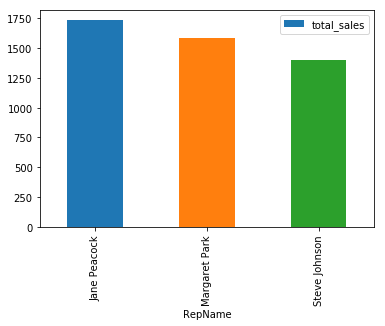

In [10]:
rep_sales = run_query(q)
rep_sales.plot.bar('RepName','total_sales')

The total sales for each rep is similar. Jane has the most sales, which is most likely because she has been there the longest, which means her cumulatie total sales have a higher probability of being larger than here peers.

In [11]:
c='''
CREATE VIEW cs AS
    SELECT
        country,
        COUNT(*) cust
    FROM customer c
    GROUP BY 1
    ORDER BY 2 DESC;         
'''
run_command(c)


In [12]:
q='''
WITH ci as 
    (SELECT c.country, SUM(inv.total) sales, 
    COUNT(DISTINCT(c.customer_id)) cust_count, COUNT(inv.invoice_id) orders
    FROM invoice inv
    INNER JOIN customer c ON c.customer_id = inv.customer_id
    GROUP BY 1
    ORDER BY 2 DESC)
    
SELECT countryname, SUM(cs.cust) cust_count, 
    SUM(ci.sales) as total, SUM(ci.sales)/SUM(cs.cust) Sales_per_cust, SUM(ci.sales)/SUM(ci.orders) Avg_order_val
    FROM
        (
        SELECT cs.*,
        CASE
            WHEN cs.cust =1 THEN 'OTHER'
            ELSE country
        END AS countryname,
        CASE
            WHEN cs.cust =1 THEN 1
            ELSE 0
        END AS sort
        FROM cs) cs
    INNER JOIN ci ON ci.country = cs.country
    GROUP BY countryname
    ORDER BY sales DESC,sort ASC
'''
run_query(q)


,countryname,cust_count,total,Sales_per_cust,Avg_order_val
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,OTHER,15,1094.94,72.996000,7.448571


In [13]:
salesbycountry = run_query(q)

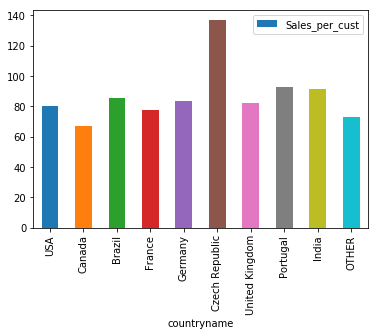

In [14]:
salesbycountry.plot.bar('countryname','Sales_per_cust')

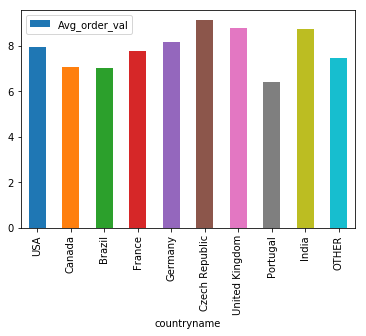

In [15]:
salesbycountry.plot.bar('countryname','Avg_order_val')

The data is interesting because we have higher average order sales and sales per customer in the Czech Republic, but it has one of the lowest customer counts.  We can't take those values at face value beacuse the sample size is so small, its a imbalanced class issue for those.  

In [17]:
#This query is teh solution query, slightly too difficult for me at this time
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668
